In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 78


In [4]:
def max_multiple(number, base=4):
    return base * int(number/base)

min_x, min_y = min(specgram.shape[1] for specgram in specgrams), specgrams[0].shape[0]
min_x_mult, min_y_mult, min_x_50 = max_multiple(min_x), max_multiple(min_x), int(1.5*min_x)
print(min_x, min_y)
print(min_x_mult, min_y_mult, min_x_50)

68 64
68 68 102


In [5]:
# Reshape spectrograms by limiting number of columns to a max
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:min_y_mult, :min_x_mult])
    if specgram.shape[1] > min_x_50:
        reshape.append(specgram[:min_y_mult, -min_x_mult:])  # if columns is > 1.5*min_size, append the last min_size columns

#Flip
augment = []
for specgram in reshape:
    augment.append(specgram)
    augment.append(np.flip(specgram, 0))  # flip rows / y axis
    augment.append(np.flip(specgram, 1))  # flip columns / x axis
    augment.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(augment))

384


In [6]:
# Obtain 3 dimensional shape
dim = augment[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(64, 68, 1)


In [7]:
# Split dataset between train and test
X_train, X_test = train_test_split(augment, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 288
Test samples: 96


In [8]:
# Add gaussian noise
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

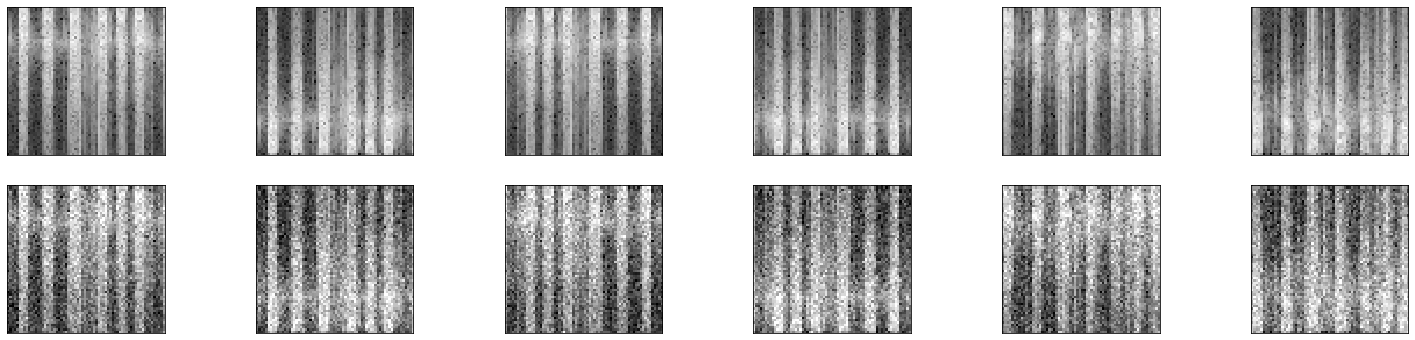

In [9]:
# Visualize original x noisy
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_train_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [10]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [11]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
bottleneck = Flatten()(code)

# decoder
x_hat = Reshape((16, 17, 2))(bottleneck)
x_hat = Conv2DTranspose(8, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(32, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 68, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 8)         6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 34, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 8)         0         
__________

In [12]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='best_model_544.h5', monitor='val_loss', save_best_only=True)]

In [13]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 250

# a variável history guarda os dados do processo de treinamento para posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 288 samples, validate on 96 samples
Epoch 1/250
288/288 [==============================] - 4s 12ms/step - loss: 0.0460 - val_loss: 0.0320
Epoch 2/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0282 - val_loss: 0.0342
Epoch 3/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0244 - val_loss: 0.0492
Epoch 4/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0215 - val_loss: 0.0309
Epoch 5/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0180 - val_loss: 0.0342
Epoch 6/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0184 - val_loss: 0.0222
Epoch 7/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0174 - val_loss: 0.0235
Epoch 8/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 9/250
288/288 [==============================] - 3s 11ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 10/250
288/288 [===============

288/288 [==============================] - 3s 10ms/step - loss: 0.0076 - val_loss: 0.0134
Epoch 160/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0079 - val_loss: 0.0111
Epoch 161/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 162/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 163/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0074 - val_loss: 0.0116
Epoch 164/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 165/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0075 - val_loss: 0.0112
Epoch 166/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 167/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 168/250
288/288 [==============================] - 3s 10ms/step - loss: 

Epoch 238/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 239/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 240/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 241/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 242/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 243/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 244/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 245/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 246/250
288/288 [==============================] - 3s 10ms/step - loss: 0.0068 - val_loss: 0.0133
Epoch 247/250
288/288 [==============================] - 3s 10ms

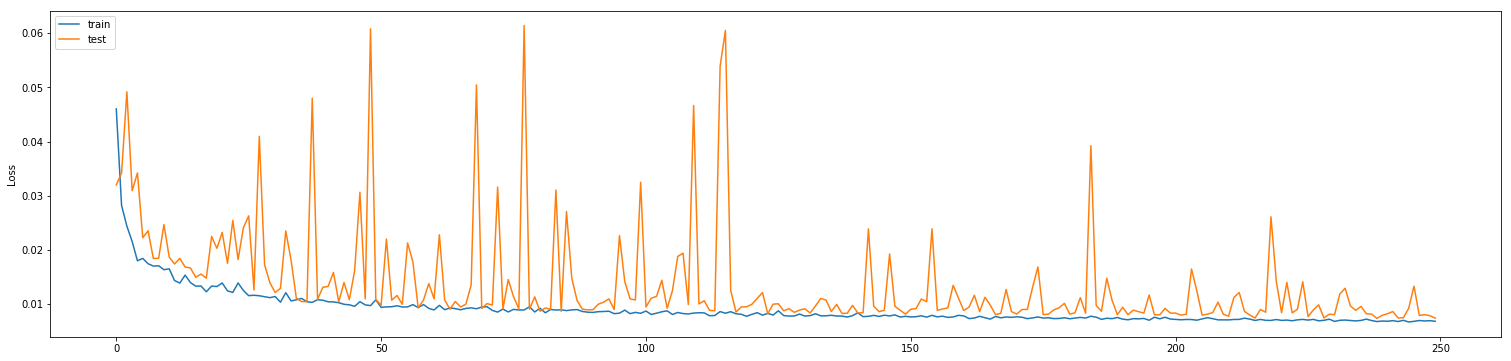

In [14]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# load best model
autoencoder = load_model('best_model_544.h5')

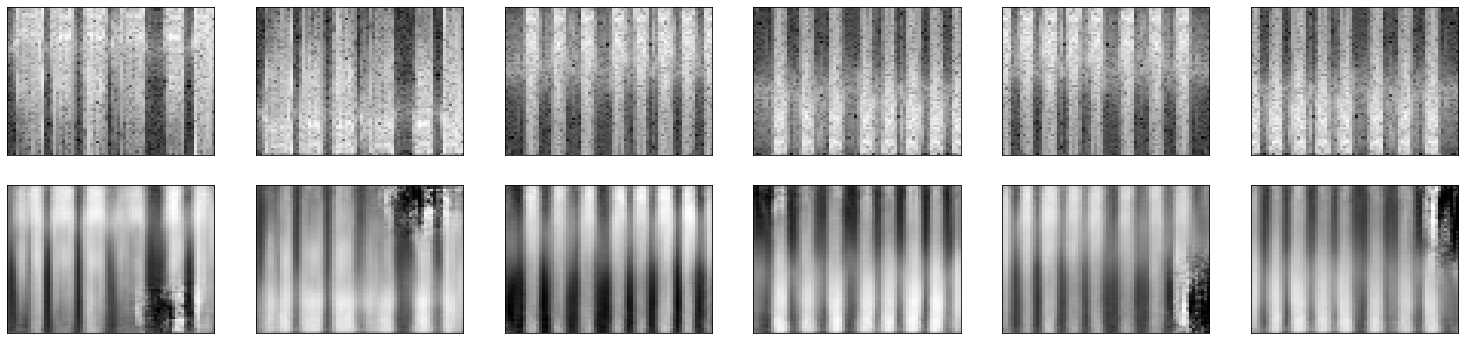

In [16]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

start, stop = 10, 16
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()